C:\Users\Alexandros Kip\AppData\Local\Temp\ipykernel_7988\2082232816.py:15: RuntimeWarning: invalid value encountered in power
  dCdt = -k1 * C**k2


Estimated Parameters: k1 = 0.1262, k2 = 2.0000


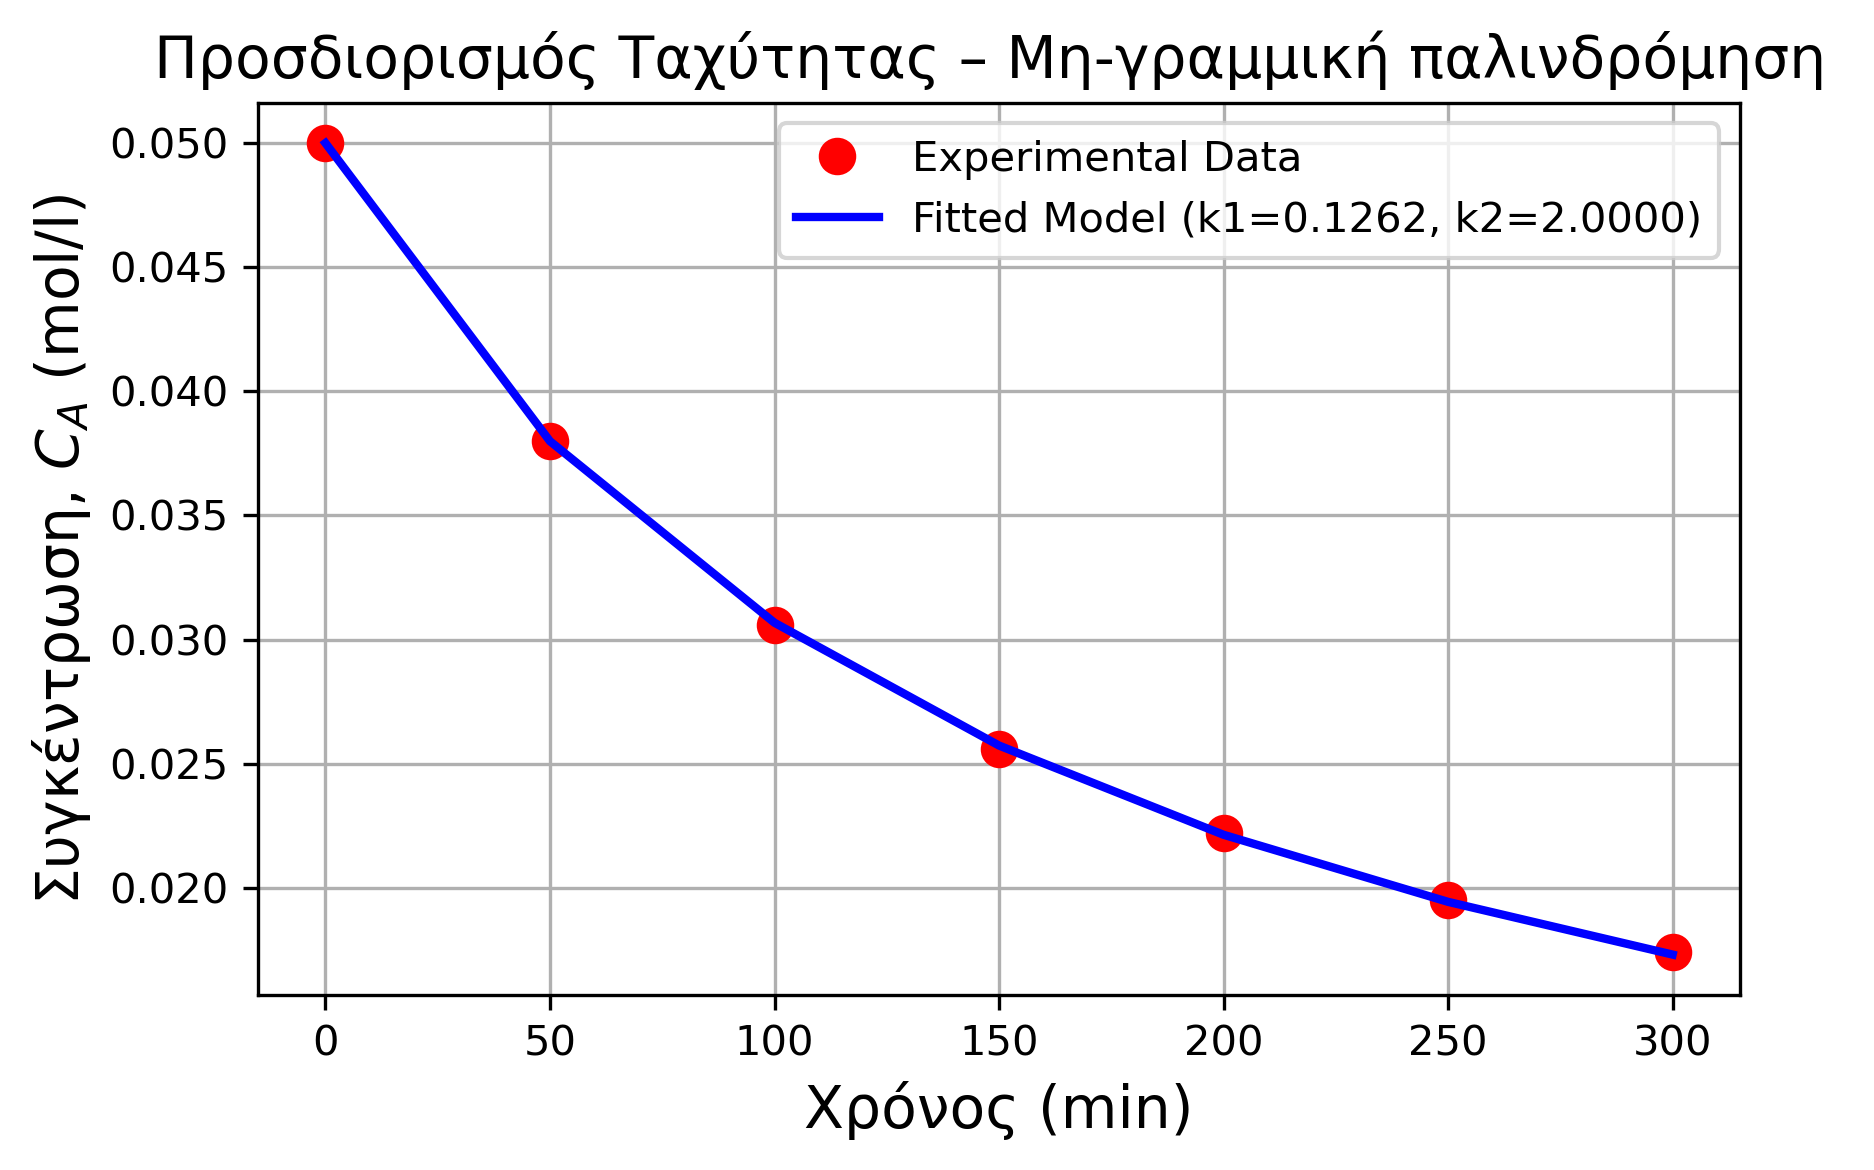

In [5]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Input experimental data (time vector and observable C)
# You can modify or input your own data here
t_data = np.array([0, 50, 100, 150, 200, 250, 300])  # Time points
C_data = np.array([0.05, 0.038, 0.0306, 0.0256, 0.0222, 0.0195, 0.0174])  # Experimental values of C

# Step 2: Define the ODE model
# ODE system: dC/dt = -k1 * C^k2
def model(t, C, k1, k2):
    dCdt = -k1 * C**k2
    return [dCdt]

# Step 3: Define a function to integrate the ODE for a given set of parameters
def simulate_ode(k, t_points, C0):
    k1, k2 = k  # Unpack parameters
    sol = solve_ivp(lambda t, C: model(t, C, k1, k2), [t_points[0], t_points[-1]], [C0], t_eval=t_points)
    return sol.y[0]  # Return C(t) over the time points

# Step 4: Define the cost function (least squares)
def cost_function(k, t_points, C_exp):
    C0 = C_exp[0]  # Initial condition for C (same as first data point)
    C_simulated = simulate_ode(k, t_points, C0)  # Simulated data from ODE model
    return np.sum((C_simulated - C_exp)**2)  # Sum of squared differences

# Step 5: Perform multi-start optimization to estimate k1 and k2
# Multi-start uses random initial guesses to avoid local minima
def multi_start_optimization(t_data, C_data, num_starts=10):
    best_params = None
    best_cost = np.inf
    for i in range(num_starts):
        # Generate random initial guesses for k1 and k2 (bounded between 0 and 2 for this example)
        initial_guess = np.random.uniform(0, 2, 2)
        result = minimize(cost_function, initial_guess, args=(t_data, C_data), bounds=[(0, 2), (0, 2)], method='L-BFGS-B')
        if result.fun < best_cost:
            best_cost = result.fun
            best_params = result.x
    return best_params

# Step 6: Estimate parameters using the multi-start optimization
estimated_params = multi_start_optimization(t_data, C_data)

# Output the estimated parameters
print(f"Estimated Parameters: k1 = {estimated_params[0]:.4f}, k2 = {estimated_params[1]:.4f}")

# Step 7: Plot the fitted model against the experimental data
C0 = C_data[0]  # Initial value of C (same as the first experimental point)
C_fitted = simulate_ode(estimated_params, t_data, C0)  # Simulate ODE with estimated parameters

# Set up high-resolution plotting
plt.rcParams["figure.dpi"] = 300

# Plot the results
plt.plot(t_data, C_data, 'ro', label="Experimental Data", markersize=8)
plt.plot(t_data, C_fitted, 'b-', label=f"Fitted Model (k1={estimated_params[0]:.4f}, k2={estimated_params[1]:.4f})", linewidth=2)

# Customizing font sizes
plt.xlabel('Χρόνος (min)', fontsize=14)
plt.ylabel('Συγκέντρωση, $C_A$ (mol/l)', fontsize=14)
plt.title('Προσδιορισμός Ταχύτητας – Μη-γραμμική παλινδρόμηση ', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True)
plt.tight_layout()  # Adjust the layout for larger fonts
plt.show()
